In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane_imager import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [4]:
config.read('scales_h2rg_imager.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))
arg_spaxel['plate_scale']=0.006
fov = (arg_spaxel['plate_scale']*arg_spaxel['detector_px'])**2
#arg_spaxel

(1600, 1600)


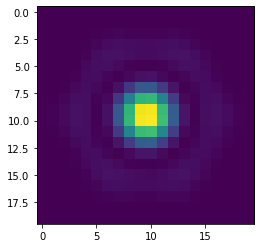

In [5]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck
print(keck.shape)

mag = magn(3.6)
W = DFT_matrix(1600, mag)
screen1 = np.zeros(W.shape)
A = pupil.pupil * np.exp(1.j * screen1)
out = abs(W.dot(A).dot(W))**2
out /= np.sum(out, axis=(0,1))
im = frebin(out, (108, 108))
plt.imshow(im[54-10:54+10,54-10:54+10])
plt.show()

## Read in Keck pupil

## Filtered phase screen for toy AO correction

In [6]:
def create_cube(lamlist,pupil):
    #mag1 = magn(lamc)
    mag1 = 1.0
    cube = []
    lamprior = 0
    for lamtmp in lamlist:
        lamc = np.round(lamtmp,2).value
        if lamc==lamprior: cube.append(keck_psf)
        else:
            psf_file = 'psfs/ps_'+str(arg_spaxel['plate_scale'])+'/keck_psf_'+str(lamc)+'_imager.fits'
            if os.path.isfile(psf_file)==False:
                print('creating '+str(lamc))
                keckp = fits.getdata('keckpupil.fits')
                mpp = 10.0/len(keckp)
                mpp_des = 1.0/(2048.0*arg_spaxel['plate_scale'])*206265.0*lamc*1.0e-6
                keckt = scipy.ndimage.zoom(keckp, mpp/mpp_des, order=0)
                keckt = np.pad(keckt,1000)
                pupil = Pupil()
                pupil.pupil = keckt
                screen1 = np.zeros(pupil.pupil.shape)
            
            
                W = DFT_matrix(len(pupil.pupil), mag1)
                A = pupil.pupil * np.exp(1.j * screen1)
                out = abs(W.dot(A).dot(W))**2
                out /= np.sum(out, axis=(0,1))
                keck_psf = frebin(out, (nspax,nspax))
                fits.writeto(psf_file,np.array(keck_psf),clobber=True)
            else:
                print('reading '+str(lamc))
                keck_psf = pyfits.getdata(psf_file)
            lamprior=lamc
            cube.append(keck_psf)
    return(np.array(cube))


Can set screen1 to zeros to leave this out

In [7]:
###Set up a target spectrum to use with the SCALES PSF
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 10.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)
print(wav)
print(I_lam)

####set this up as a Target
targ = Target(wav,I_lam)

[0.05     0.05001  0.05002  ... 5.499925 5.49995  5.499975]
[1.2782356e-15 1.2860823e-15 1.2958241e-15 ... 1.2565724e-08 1.2565280e-08
 1.2564963e-08]


In [10]:
bands = ['J','H','Ks','Lp','Ms']
for band in bands:
    print(band)
    ofile = 'scales_imager_Astar_10pc_'+band+'_ps'+str(arg_spaxel['plate_scale'])+'.fits'
    if os.path.isfile(ofile)==False:
        print('generating '+ofile)
    
        nspax = arg_spaxel['detector_px']

    
        vapor = 1 #PWV in mm
        airmass = 1 
        skybg = SkyBG(vapor,airmass)
        skytrans = SkyTrans(vapor,airmass)
        atmodisp = AtmoDispersion(90,20,600)

        telAO_emissivities = [0.4]
        telAO_temps = [285*u.K]
        scales_trans = [0.616]
        inst = InstTransEm(telAO_emissivities, telAO_temps, scales_trans)
        qe = QE(0.88) ##detector 6 is ~0.8, detector 8 is 0.88 -- testing "worst case" for saturation using detector 8
    
    
        filt = ImagerFilter(filename='nirc2_'+band+'.txt')
        dit = 1 ###integration time in seconds
    
        ####organize all these and pass to focal_plane 
        args_new = {
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe,
            'FOV':fov, ###fov in square arcsec
            'area':arg_spaxel['area'],
            'DetectorPix':2048
                }
        fp = FocalPlaneImager(args_new)
        print(fp.lam)
    
    
        cube = create_cube(fp.lam,pupil)
        print(cube.shape)
        plt.imshow(cube[0][950:1100,950:1100])
        plt.show()
    
    
        #raw = fp.get_fp(dit*u.s,return_full=True,bg_off=False, return_phots=True) ###for sky
        
        raw = fp.get_fp(dit*u.s,Target=targ, PSF=cube,return_full=True,bg_off=False, return_phots=True)*0.88 #multiply by QE
        print('writing '+ofile)
        pyfits.writeto(ofile, np.array(raw))
        plt.imshow(raw)
        plt.show()
    else: raw = pyfits.getdata(ofile)

J
H
Ks
Lp
Ms


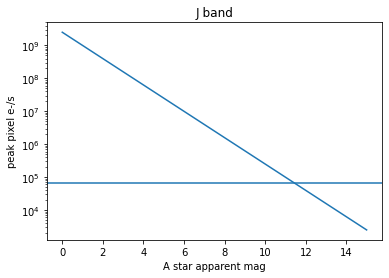

[11.4]


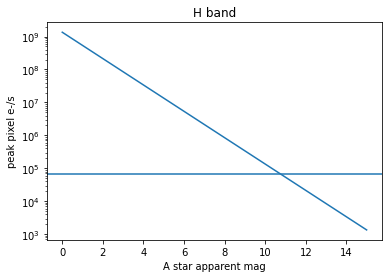

[10.8]


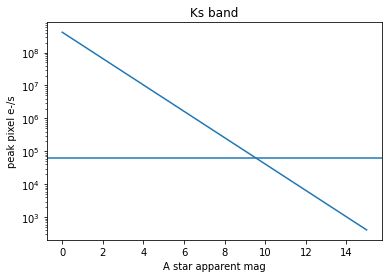

[9.45]


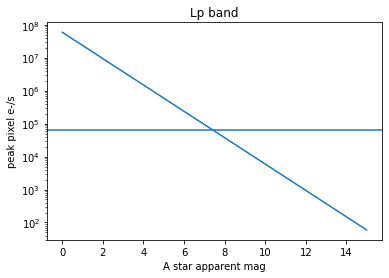

[7.35]


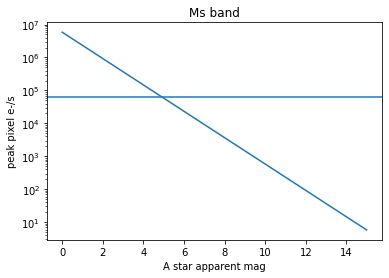

[4.95]


In [11]:
for band in bands:
    ofile = 'scales_imager_Astar_10pc_'+band+'_ps'+str(arg_spaxel['plate_scale'])+'.fits'
    raw = pyfits.getdata(ofile)
    im = raw.copy()
    mpixs = []
    f = plt.figure()
    plt.title(band + ' band')
    amags = np.linspace(0.0,15.0,101)
    for amag in amags:
        im2 = im * 10**(-amag/2.5)
        mpix = np.max(im2)
        mpixs.append(mpix)
        
    plt.plot(amags,mpixs)
    plt.xlabel('A star apparent mag')
    plt.ylabel('peak pixel e-/s')
    plt.yscale('log')
    plt.axhline(65000)
    plt.show()
    mpixs = np.array(mpixs)
    print(amags[np.where(np.abs(mpixs-65000.0)==np.min(np.abs(mpixs-65000.)))])